In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import statistics as st

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Precipitation Analysis

### Measurement Columns
##### *, Prcp, Station, Tobs, Date, ID
### Station Columns
##### *, ID, Elevation, Latitude, Station, Longitude, Name

In [9]:
# Find the most recent date in the data set.
dates = []
for row in session.query(Measurement.date):
    dates.append(row)
date = max(dates)
print(f"Most Recent Date: {date}")
print(f"12 Month Date: ('2016-08-24',)")

Most Recent Date: ('2017-08-23',)
12 Month Date: ('2016-08-24',)


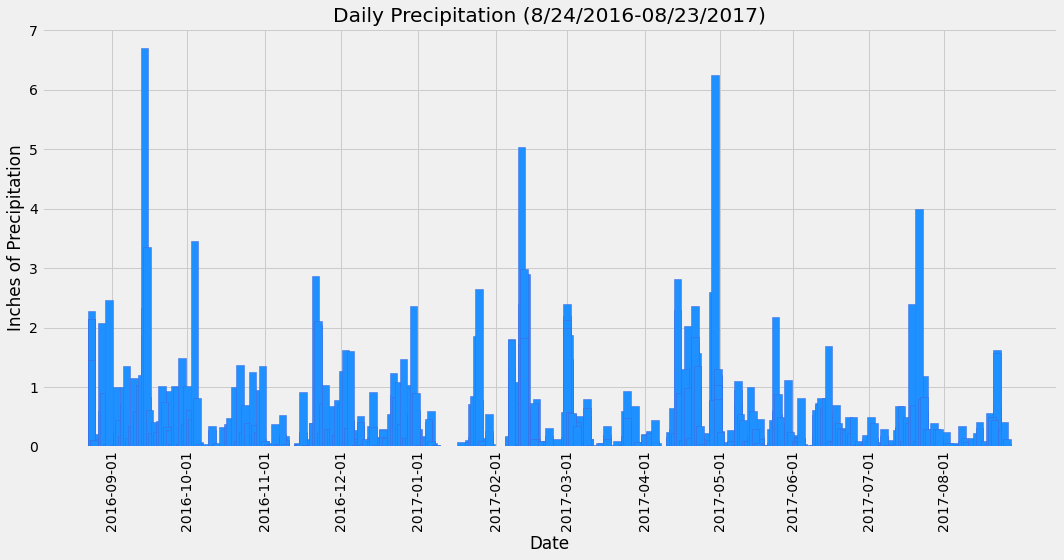

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
date = dt.datetime(2016, 8, 23)
dates12 = []
prcps12 = []
# Perform a query to retrieve the data and precipitation scores
for row in session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date):
    dates12.append(row[0])
    prcps12.append(row[1])
# Save the query results as a Pandas DataFrame and set the index to the date column
months12 = pd.DataFrame()
months12["Date"] = dates12
months12["Precip."] = prcps12
months12.set_index("Date")
# Sort the dataframe by date
months12.sort_values("Date")
# Use Pandas Plotting with Matplotlib to plot the data
x = months12["Date"].tolist()
y = months12["Precip."].tolist()
plt.figure(figsize=(15,8))
plt.bar(x,y,width=3,fc="dodgerblue",ec='royalblue')
plt.ylabel("Inches of Precipitation")
plt.xlabel("Date")
plt.xticks(['2016-09-01','2016-10-01','2016-11-01','2016-12-01','2017-01-01','2017-02-01',
           '2017-03-01','2017-04-01','2017-05-01','2017-06-01','2017-07-01','2017-08-01'], rotation='90')
plt.title("Daily Precipitation (8/24/2016-08/23/2017)")
plt.tight_layout()
plt.savefig("Results/Daily_Precipitation.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
months12.describe()

,Precip.
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).group_by(Station.id).count()
print(f"There are {station_count} stations.")

There are 9 stations.


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = []
counts = []
for row in session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station):
    stations.append(row[0])
    counts.append(row[1])
stations_df = pd.DataFrame()
stations_df["Station IDs"] = stations
stations_df["Counts"] = counts
stations_df.sort_values("Counts",ascending=False,inplace=True)
print(f"The station with the most readings is Station ID: {stations_df['Station IDs'][6]}")
stations_df

The station with the most readings is Station ID: USC00519281


,Station IDs,Counts
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = stations_df['Station IDs'][6]
ma_temps = []
for row in session.query(Station.name).filter(Station.station == most_active):
    station_name = row[0]
for row in session.query(Measurement.tobs).filter(Measurement.station == most_active):
    ma_temps.append(row[0])
print(f"(Station Number {most_active}) {station_name}:")
print(f"High Temperature: {max(ma_temps)} degrees.")
print(f"Low Temperature: {min(ma_temps)} degrees.")
print(f"Average Temperature: {round(st.mean(ma_temps),1)} degrees.")

(Station Number USC00519281) WAIHEE 837.5, HI US:
High Temperature: 85.0 degrees.
Low Temperature: 54.0 degrees.
Average Temperature: 71.7 degrees.


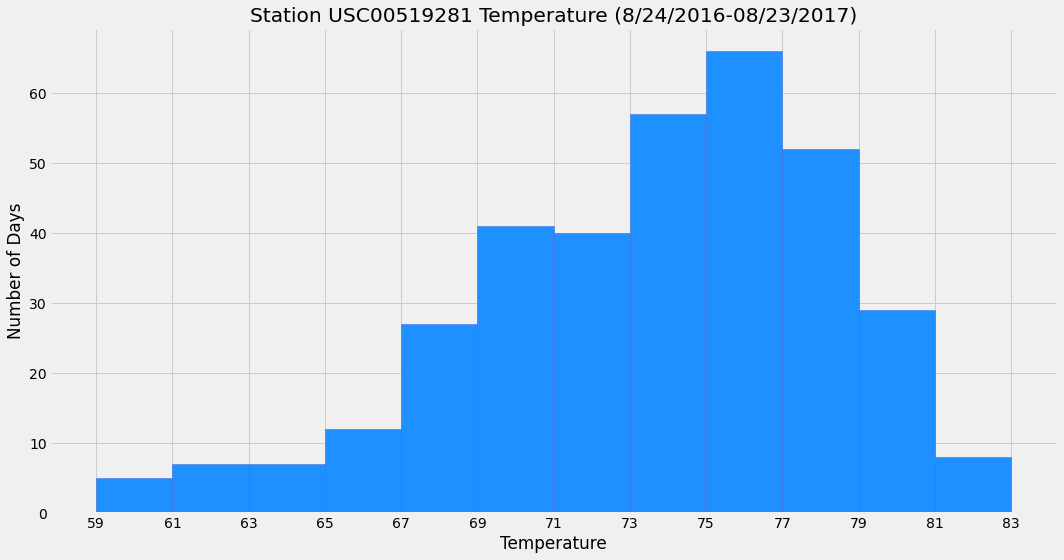

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
ma_dates = []
ma_temps = []
for row in session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > date).\
            filter(Measurement.station == most_active):
    ma_dates.append(row[0])
    ma_temps.append(row[1])
ma = pd.DataFrame()
ma["Date"] = ma_dates
ma["Temp."] = ma_temps
ma.set_index("Date")
ma.sort_values("Date")
x = ma["Temp."].tolist()
plt.figure(figsize=(15,8))
plt.hist(x,bins=12,fc="dodgerblue",ec='royalblue')
plt.ylabel("Number of Days")
plt.xlabel("Temperature")
plt.xticks([59,61,63,65,67,69,71,73,75,77,79,81,83])
plt.title(f"Station {most_active} Temperature (8/24/2016-08/23/2017)")
plt.tight_layout()
plt.savefig(f"Results/Station_{most_active}_Temperature.png")
plt.show()

# Close session

In [16]:
# Close Session
session.close()